In [0]:
import pandas as pd
import numpy as np

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score

import eli5
from eli5.sklearn import PermutationImportance

## Dane

In [7]:
df=pd.read_hdf('data/car.h5')
df.shape

(106494, 155)

In [10]:
df.columns

Index(['breadcrumb', 'created_at', 'price_currency', 'price_details',
       'price_value', 'seller_address', 'seller_name', 'seller_type',
       'feature_czujniki-parkowania-przednie',
       'feature_poduszka-powietrzna-chroniąca-kolana',
       ...
       'param_pearl', 'param_stan', 'param_wersja', 'param_emisja-co2',
       'param_body-type', 'param_matowy', 'param_bezwypadkowy',
       'param_akryl-(niemetalizowany)', 'param_monthly-payment-value',
       'car_id'],
      dtype='object', length=155)

## Dummy model

In [11]:
#check what numerical columns are available
df.select_dtypes(np.number).columns

Index(['price_value', 'car_id'], dtype='object')

In [0]:
#remove values in euro - below 0.19%
df=df[df['price_currency']!='EUR']

In [21]:
#prepare X and y for the model
feats=['car_id']
X=df[feats].values
y=df['price_value'].values

#create model, train, predict
model=DummyRegressor()
model.fit(X,y)
y_pred=model.predict(X)

#check error
mae(y,y_pred)

39456.885927541574

## Features

In [28]:
#factorise values
suf='__cat'
for feat in df.columns:
  if isinstance(df[feat][0],list):continue

  factorised_values=df[feat].factorize()[0]

  if suf in feat:
    df[feat]=factorised_values
  else:
    df[feat+suf]=factorised_values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [32]:
# factorised columns without price
cat_feats= [x for x in df.columns if suf in x]
cat_feats= [x for x in cat_feats if 'price' not in x]
len(cat_feats)

151

In [34]:
#new X, y
X=df[cat_feats].values
y=df['price_value'].values

#crate, train and test model
model=DecisionTreeRegressor(max_depth=5)
scores=cross_val_score(model,X,y,cv=3,scoring='neg_mean_absolute_error')
np.mean(scores)

-19566.588937368324

In [36]:
#finding features
m=DecisionTreeRegressor(max_depth=5)
m.fit(X,y)

imp=PermutationImportance(m, random_state=0).fit(X,y)
eli5.show_weights(imp,feature_names=cat_feats)

Weight,Feature
0.2533 ± 0.0040,param_napęd__cat
0.2008 ± 0.0047,param_faktura-vat__cat
0.1943 ± 0.0088,param_stan__cat
0.1423 ± 0.0086,param_rok-produkcji__cat
0.0629 ± 0.0047,param_moc__cat
0.0424 ± 0.0014,feature_kamera-cofania__cat
0.0412 ± 0.0008,param_skrzynia-biegów__cat
0.0286 ± 0.0037,param_marka-pojazdu__cat
0.0191 ± 0.0022,param_pojemność-skokowa__cat
0.0163 ± 0.0005,feature_bluetooth__cat


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3029b3a550>,
      dtype=object)

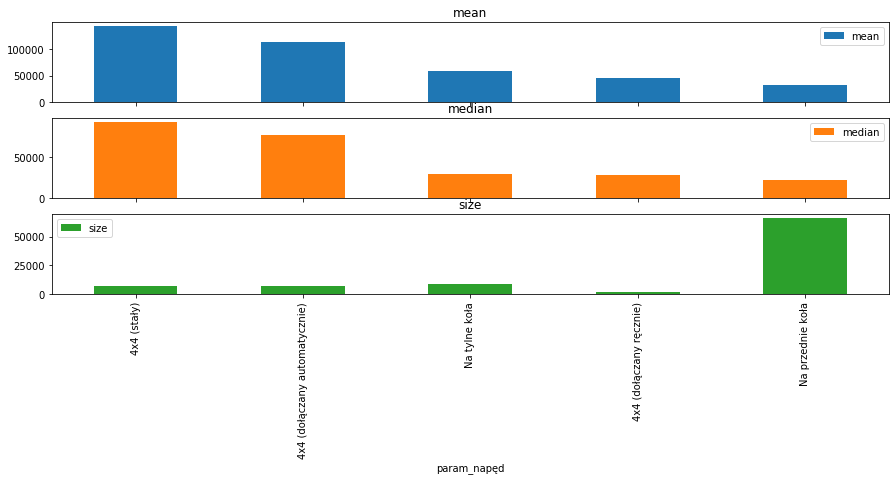

In [52]:
df.groupby('param_napęd').price_value.agg([np.mean, np.median, np.size]).sort_values(by='mean',ascending=False).head(500).plot(kind='bar', figsize=(15,5), subplots=True)